## TASK 1 : Demand Estimation

This code imports all the needed data sets (rasters,geojson) and then generates one csv file containing the annual electricity demand for each settlement over a 15 years. 

1. Setting Assumptions
The code starts by defining the key modeling parameters that influence demand projections:
- Planning Horizon: The simulation runs for 15 years (from a START_YEAR of 2025).
- Household Size: A fixed value (household_size = 5) is used to convert the total population of each settlement into the number of households.
- Annual Demand Growth: A growth factor (annual_demand_growth = 0.0243 or 2% per year : Benin 2025 growth) is applied. 
- Productivity Fraction: A fixed percentage (20%) is used to estimate the portion of total demand that is non-residential (i.e., productive use or institutional demand, such as schools, clinics, and small businesses).

2. Setting the Target Energy Level (MTF Justification)
The assignment requires justifying the level of service (Tier). This is achieved by linking geospatial and socio-economic data to the Multi-Tier Framework (MTF) levels.
The select_tier function assigns a Target Tier (Tier 1 to 4) to each settlement based on a set of rules:
Based on the Relative Wealth Index (RWI), the Building Density Percentage (bd_pct), and the presence of Night Lights (has_nl) as indicators of development and existing energy access.
The RWI and Building Density thresholds were calibrated using percentiles of the Benin dataset's full range of values (RWI: -0.46 to +1.53; Building Density: 0% to 31%).
 - Settlements with high RWI, high building density, and night light presence are assigned Tier 4 (high consumption, typical of dense urban centers).
 - Settlements with medium RWI and night light presence are typically assigned Tier 3 (medium consumption, covering basic appliances like fans and a small refrigerator).
 - Poorer or very remote settlements are assigned Tier 1 or 2.

Tier Mapping: The final selected_tier column determines the target annual residential kWh consumption for each household using the tier_to_kwh dictionary (e.g., Tier 4 maps to 2117 kWh/year).

3. Calculating Initial Demand (Year 0)
This step uses the assigned Tier and the initial settlement data to establish the demand for the start year (Year 0, 2025)
Household Count: The population is divided by the household_size to create the Households column.
Base Residential Demand: The calculated selected_tier is mapped to the corresponding annual kWh per household value, forming the ResidentialDemandTierCustom column. This is the core residential demand input for OnSSET.
Total Demand Conversion: The original input column (demand, which is in kWh/day for Year 0) is converted to Total Annual Demand for Year 0 (total_demand_yr0).
The Total Demand is split into two parts based on the productivity_fraction:
Residential Demand (Year 0): This is the bulk of the demand, calculated as total_demand_yr0 / (1 + productivity_fraction).
Productive Demand (Year 0): This is the remainder, calculated as residential_demand_yr0 * productivity_fraction.

4. Projection over the Planning Horizon
A loop is executed for every year from Year 0 to Year 15 (2025 to 2040) to project future demand:
- Growth Factor: For each year, a growth_factor is calculated using annual growth based on the 2,43% annual_demand_growth.
- Projection: The baseline demands (Year 0 Residential and Productive) are multiplied by the accumulated growth_factor for that year.
- Output Columns: New columns are created for each year, such as residential_demand_yr1, productive_demand_yr1, and total_demand_yr1, ensuring the demand estimates for both residential and productive sectors are available for the entire planning horizon.

In [50]:
# Data Loading
import os
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.sample import sample_gen
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt # Import for plotting

# Files
INPUT_GEOJSON = "data/Benin_settlement_properties.geojson"
METRIC_CRS = "EPSG:32631" # WGS 84 / UTM Zone 31N (Suitable for Benin)
WGS84_CRS = "EPSG:4326"

# Main settlement data
gdf = gpd.read_file(INPUT_GEOJSON)
gdf = gdf.to_crs(WGS84_CRS)

# Assumptions and parameters
START_YEAR = 2025
household_size = 5               
horizon_years = 15                
annual_demand_growth = 0.0243      
productivity_fraction = 0.20      

# Multi-Tier Framework (MTF) developed by the World Bank.
tier_to_kwh = {
    1: 38.7 ,   # Basic lighting)
    2: 219,     
    3: 803,     
    4: 2117,    
    5: 2993     # High consumption
}
# Consumption level function
def select_tier(row):
    rwi = row.get("mean_rwi", 0.3)
    has_nl = bool(row.get("overlap_percentage", False)) 
    bd_pct = row.get("building_density_percent", 0.0)

    if has_nl and rwi > 0.45 and bd_pct > 10:
        return 4
    if has_nl and rwi > 0.30:
        return 3
    if rwi > 0.45 and bd_pct > 5:
        return 3
    if rwi > 0.1:
        return 2
    return 1

# Apply the function and create column
gdf["selected_tier"] = gdf.apply(select_tier, axis=1)


gdf["kwh_per_household_yr0"] = gdf["selected_tier"].map(tier_to_kwh)
gdf["Households"] = gdf["population"] / household_size
gdf["ResidentialDemandTierCustom"] = gdf["kwh_per_household_yr0"] 

years = list(range(0, horizon_years + 1)) 
#Loop for 15 years
for y in years:
    if y == 0:
        # Initial Total Demand (kWh/year)
        gdf["total_demand_yr0"] = gdf["demand"] * 365.25
        # Separation of Residential Demand
        gdf["residential_demand_yr0"] = gdf["total_demand_yr0"] / (1 + productivity_fraction)
    
    # Growth Factor
    growth_factor = (1 + annual_demand_growth) ** y

    # Projected Residential Demand
    gdf[f"residential_demand_yr{y}"] = gdf["residential_demand_yr0"] * growth_factor

    # Projected Productive/Institutional Demand
    gdf[f"productive_demand_yr{y}"] = gdf[f"residential_demand_yr{y}"] * productivity_fraction
    
    # Projected Total Demand
    gdf[f"total_demand_yr{y}"] = gdf[f"residential_demand_yr{y}"] + gdf[f"productive_demand_yr{y}"]

#Export GDF
gdf.drop(columns=['geometry'])
gdf.to_csv("results/Task1/Benin_settlements_2040_T1.csv", sep=';', index=False, float_format='%.4f')
print(f"All settlement data exported successfully to: results/Task1/Benin_settlements_2040_T1.csv")
# Display the first few rows and only the relevant demand columns for verification
cols_to_show = ['population', 'Households', 'selected_tier', 'residential_demand_yr0', 'productive_demand_yr0', 'total_demand_yr15']


All settlement data exported successfully to: Results/Task1/Benin_settlements_2040_T1.csv


## TASK 2.1 : Technology Options & Least-Cost Analysis (Data cleaning and CSV Export)

This section prepares the settlement GeoDataFrame (gdf) for the Least-Cost Electrification Analysis using the OnSSET model. Its goal is to transform the data from Task 1 into a CSV file that adheres to the exact format and column order required by the OnSSET input tool.
The script performs the following key steps:
- Renames existing columns to match OnSSET's conventions (e.g., lat to Y_deg, population to Pop).
- Initializes default distance variables, placeholder demand columns (Anchor Loads), and status flags.
- Clean the Land Cover codes to the numerical indices used by the OnSSET model.
- Calculates the PerCapitaDemand and defines the standard MTF Residential Demand tiers used for LCOE calculations.
- Selects and reorders all columns strictly according to the OnSSET template, then exports the final table to Output_Mycode.csv.


This cell handles the extraction of raster data points (like GHI and LandCover) into the GeoDataFrame. 

**Ensure your TIFF files are in the same directory as this notebook.**

In [51]:
# List of rasters to extract: Output column name as key, file path as value
rasters = {
    'GHI': 'data/GHI.tif',
    'Slope': 'data/slope.tif',
    'Elevation': 'data/elevation.tif',
    'LandCover': 'data/landcover.tif'
    #'Nighttime': 'data/ntl.tif' #Not used in the end
}

# Function to sample raster at a point
def sample_raster(raster_path, lon, lat):
    try:
        with rasterio.open(raster_path) as src:
            # Check for CRS difference and transform if necessary (WGS84 to Raster CRS)
            if src.crs.to_string() != 'EPSG:4326':
                from pyproj import Transformer
                transformer = Transformer.from_crs('EPSG:4326', src.crs.to_string(), always_xy=True)
                lon, lat = transformer.transform(lon, lat)
            
            # Sample the raster at the coordinate
            for val in src.sample([(lon, lat)]):
                return val[0]
    except rasterio.RasterioIOError:
        print(f"Warning: Raster file not found at {raster_path}. Setting value to 0.")
        return 0.0 # Return 0.0 if file is missing
    except Exception as e:
        print(f"An error occurred while sampling {raster_path}: {e}")
        return 0.0

# Extract raster values
for col, raster_path in rasters.items():
    gdf[col] = gdf.apply(lambda row: sample_raster(raster_path, row['lon'], row['lat']), axis=1)
print("Raster extraction complete.")

Raster extraction complete.


This cell performs all the necessary column renaming, data type transformations (Land Cover), and calculation of default distance columns required by the OnSSET model.

In [52]:
# Column rename
gdf.rename(columns={
    'lon': 'X_deg',
    'lat': 'Y_deg',
    'identifier': 'id',
    'dist_to_substations': 'SubstationDist',
    'dist_main_road_km': 'RoadDist',
    'overlap_percentage': 'NightLights',
    'hull_area': 'GridCellArea', 
    'population': 'Pop',
}, inplace=True)

#Landcover
gdf['LandCover'] = pd.to_numeric(gdf['LandCover'], errors='coerce').fillna(0).astype(int)
# Filter values: remove values that are negative or > 16 (setting them to 9 - Bare Area)
# 1. Set values > 16 to 9
gdf['LandCover'] = np.where(
    gdf['LandCover'] > 16, 
    9, 
    gdf['LandCover']
)
# 2. Set values < 1 (negative or 0 from fillna/coercion) to 9
gdf['LandCover'] = np.where(
    gdf['LandCover'] < 1, 
    9, 
    gdf['LandCover']
)

# Initialization
gdf['Country'] = 'Benin'
gdf['WindVel'] = 0.0    # Not used in this model
gdf['HealthDemand'] = 0
gdf['EducationDemand'] = 0
gdf['AgriDemand'] = 0
gdf['CommercialDemand'] = 0
gdf['ElectrificationOrder'] = 0
gdf['IsUrban'] = 0
gdf['TransformerDist'] = 9999
gdf['HydropowerDist'] = 9999
gdf['Hydropower'] = 9999.0
gdf['HydropowerFID'] = 9999

# Calculate Electrified Population (ElecPop) and if has_nightlight = False set NightLights=0
gdf["ElecPop"] = np.where(gdf['has_nightlight'] == True, gdf['Pop'], 0.0)
gdf['NightLights'] = np.where(gdf['has_nightlight'] == False, 0.0, gdf['NightLights'])

# Travel Column
gdf['TravelHours'] = gdf['dist_nearest_hub_km'] / 20 # 20km/h average in Benin

#Distance to transmission lines
gdf['CurrentHVLineDist'] = gdf['distance_to_existing_transmission_lines']
gdf['PlannedHVLineDist'] = gdf['distance_to_planned_transmission_lines']
gdf['CurrentMVLineDist'] = gdf['distance_to_existing_transmission_lines'] # Assuming MV/HV is same distance for simplicity
gdf['PlannedMVLineDist'] = gdf['distance_to_planned_transmission_lines'] # Assuming MV/HV is same distance for simplicity

# Per Capita Demand: Residential demand per household (Task 1) divided by household size
gdf['PerCapitaDemand'] = gdf['ResidentialDemandTierCustom'] / household_size

# MTF Tier Demand (kWh/year - standard OnSSET LCOE input values)
gdf['ResidentialDemandTier1'] = 7.74
gdf['ResidentialDemandTier2'] = 43.8
gdf['ResidentialDemandTier3'] = 200
gdf['ResidentialDemandTier4'] = 500
gdf['ResidentialDemandTier5'] = 750

This cell is the final stage of data preparation, ensuring the GeoDataFrame is structured, cleaned, and exported in the exact format required as input for the OnSSET (Open Source Spatial Electrification Tool) model.

In [57]:
# List of columns in the EXACT order expected by the OnSSET model
onsset_cols_order = [
    'X_deg', 'Y_deg', 'Pop', 'GridCellArea', 'Country', 'ElecPop', 'WindVel', 
    'GHI', 'TravelHours', 'Elevation', 'ResidentialDemandTierCustom', 'Slope', 
    'NightLights', 'LandCover', 'SubstationDist', 'TransformerDist', 
    'CurrentHVLineDist', 'PlannedHVLineDist', 'CurrentMVLineDist', 
    'PlannedMVLineDist', 'RoadDist', 'HydropowerDist', 'Hydropower', 
    'HydropowerFID', 'IsUrban', 'PerCapitaDemand', 'HealthDemand', 
    'EducationDemand', 'AgriDemand', 'ElectrificationOrder', 'CommercialDemand', 
    'ResidentialDemandTier1', 'ResidentialDemandTier2', 'ResidentialDemandTier3', 
    'ResidentialDemandTier4', 'ResidentialDemandTier5', 
    'id', 'Households', 'Conflict' 
]

# Ensure only required and existing columns are selected
cols_to_export = [col for col in onsset_cols_order if col in gdf.columns]

gdf_onsset_ready = gdf.reindex(columns=cols_to_export)
# Fill any missing values (NaNs) with 0
gdf_onsset_ready = gdf_onsset_ready.fillna(0) 

#Export to CSV
gdf_onsset_ready.to_csv("results/Task2/Calibrated_Input_OnSSET_T2.csv",index=False,sep=';',float_format='%.4f') 
print(f"CSV file for OnSSET input was exported to : results/Task2/Calibrated_Input_OnSSET_T2.csv")

CSV file for OnSSET input was exported to : results/Task2/Calibrated_Input_OnSSET_T2.csv


This cell will run the OnSSET model with the exported CSV


OnSSET input file (results/OnSSET/Task2/Calibrated_Input_OnSSET_T2.csv) is ready.
Automatically launching the OnSSET Notebook...


#### The csv file has been imported correctly. Here is a preview:

,X_deg,Y_deg,Country,Pop,NightLights,ElecPop,GHI,CurrentMVLineDist,HydropowerDist
2837,1.6187,10.2023,Benin,698,0.0000,0.0,2022,20.6499,9999
14558,2.6200,7.3264,Benin,237,0.0000,0.0,1720,1.4015,9999
2744,2.5567,8.3686,Benin,77,0.0000,0.0,1782,5.2940,9999
2440,1.8777,6.4786,Benin,80,0.0000,0.0,1727,14.0848,9999
6229,1.8286,6.5568,Benin,67,0.0000,0.0,1718,4.3483,9999
16523,1.7793,6.9774,Benin,222,0.0000,0.0,1769,19.4771,9999
12322,1.8054,10.5913,Benin,49,0.0000,0.0,2031,60.0847,9999
12580,2.1077,6.8013,Benin,665,0.0000,0.0,1724,14.5076,9999
4034,2.5285,9.1165,Benin,46,0.0000,0.0,1875,0.4819,9999
9266,2.6682,10.3715,Benin,88,0.0000,0.0,2021,18.4449,9999


We have identified the existence of MV lines as input data; therefore we proceed using those for the calibration
Not enough urban or rural population meet the criteria. Calibrating to match total electrified population only
The modelled electrification rate differ by -0.00. Urban elec. rate differ by -0.00 and Rural elec. rate differ by 0.00. 
If this is not acceptable please revise this part of the algorithm


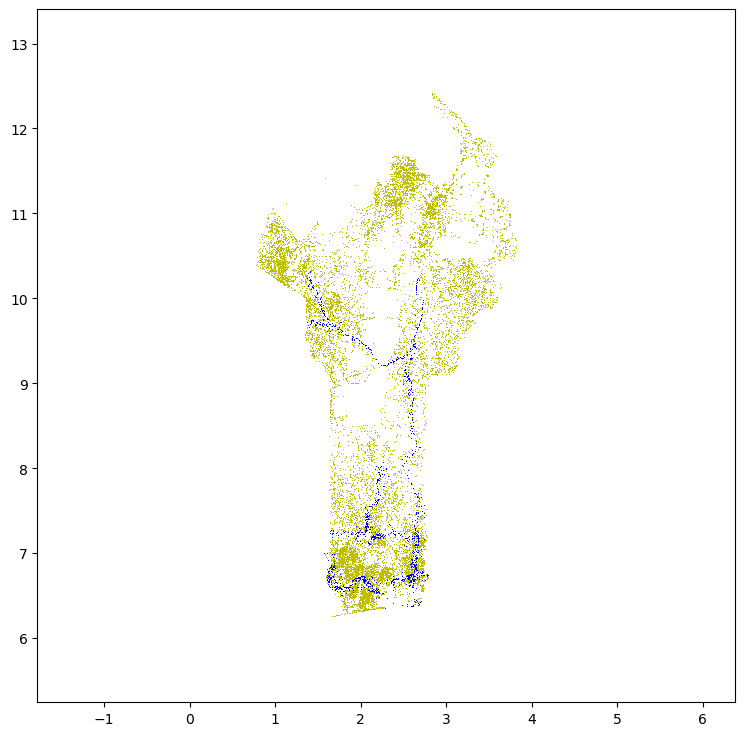

<Figure size 3000x3000 with 0 Axes>

/Users/Gregoire/Documents/VIDA/onsset-master/onsset/onsset.py:1189: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8878 2.7707 2.5684 ... 0.     3.1755 1.0623]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df[SET_ELEC_CURRENT] == 1, SET_MV_CONNECT_DIST] = self.df[SET_HV_DIST_CURRENT]
/Users/Gregoire/Documents/VIDA/onsset-master/onsset/onsset.py:1584: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[160.6 160.6 160.6 ... 160.6 160.6 160.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df[SET_URBAN] == 0, SET_CAPITA_DEMAND] = self.df[
/Users/Gregoire/Documents/VIDA/onsset-master/onsset/onsset.py:1213: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ve

The electrification rate achieved in 2030 is 75.0 %


/Users/Gregoire/Documents/VIDA/onsset-master/onsset/onsset.py:1213: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df[SET_ELEC_FINAL_CODE + "{}".format(year - time_step)] == 1,


The electrification rate achieved in 2040 is 100.0 %


### Summary 
 These are the summarized results for full electrification of the selected country by the final year

/var/folders/jj/4xmmb0y578l37fgqqtzh1wm40000gn/T/ipykernel_86730/3184299251.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
/var/folders/jj/4xmmb0y578l37fgqqtzh1wm40000gn/T/ipykernel_86730/3184299251.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
/var/folders/jj/4xmmb0y578l37fgqqtzh1wm40000gn/T/ipykernel_86730/3184299251.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for 

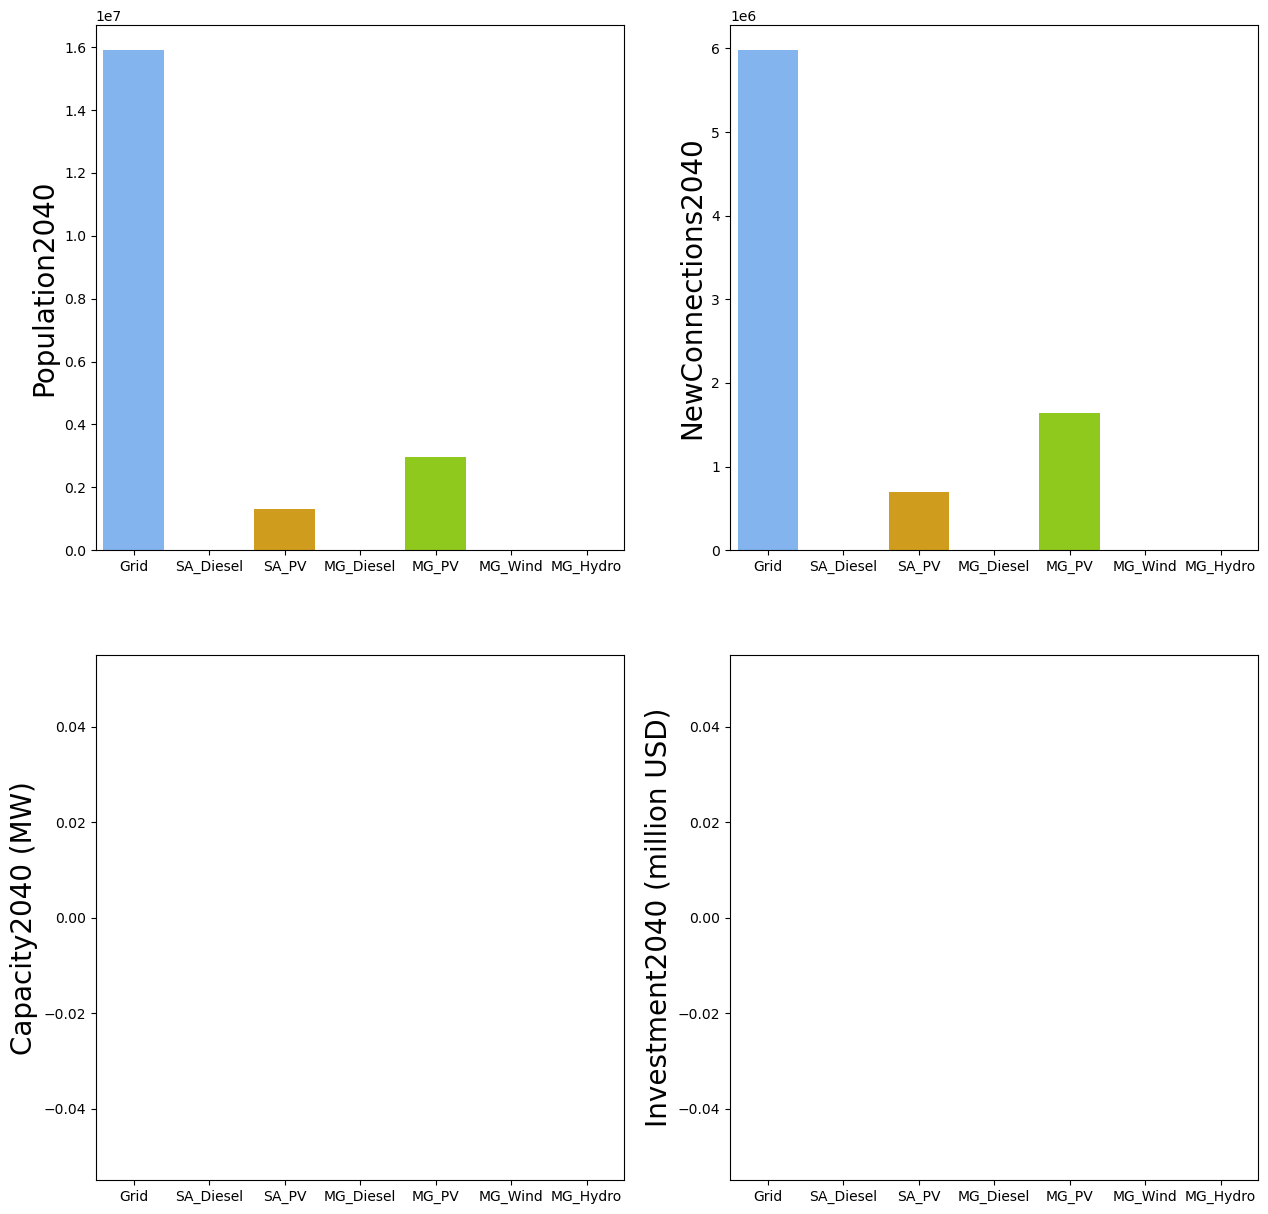

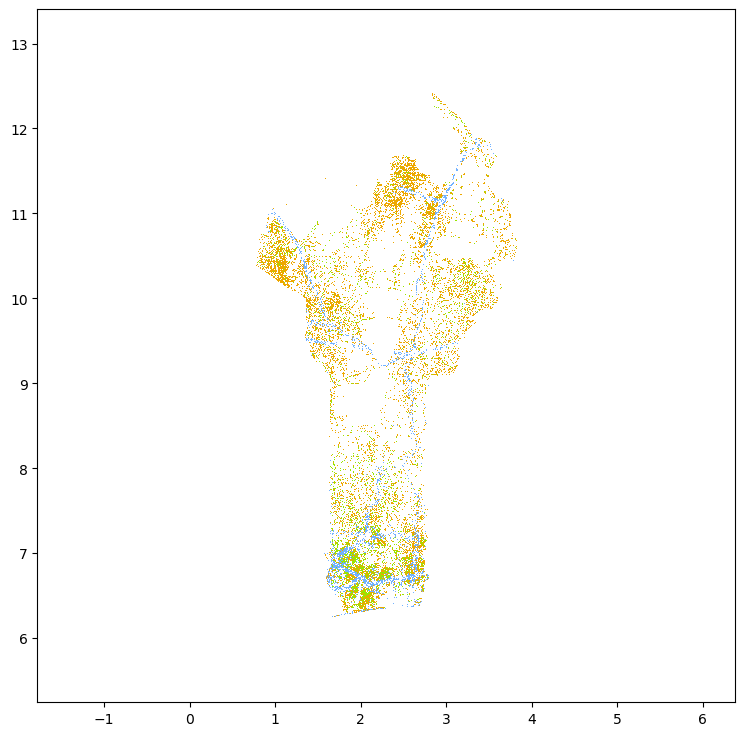

<Figure size 3000x3000 with 0 Axes>

In [60]:
ONSSET_PATH = "onsset-master/OnSSET_notebook.ipynb"
# Check if the output file is ready
if os.path.exists("results/Task2/Calibrated_Input_OnSSET_T2.csv"):
    print(f"\nOnSSET input file (results/OnSSET/Task2/Calibrated_Input_OnSSET_T2.csv) is ready.")
    print("Automatically launching the OnSSET Notebook...")
    
    # Executes all cells in the OnSSET_notebook.ipynb in sequence.
    %run "$ONSSET_PATH"
else:
    print("\nError: The OnSSET input file was not found. Please run it seperatly")

This cell cleans and re-export the OnSSET result file

In [65]:
# Load the OnSSET results file. Assumes comma (,) delimiter.
df_results = pd.read_csv('Results/OnSSET/Benin_2040_scenarios_Results.csv', delimiter=',')
# Col Selection
essential_cols = [
    'id', 
    'X_deg', 
    'Y_deg',
    'Pop2040',
    'Households',
    'Tier',
    'TotalEnergyPerCell',
    'FinalElecCode2040',
    'MinimumOverallLCOE2040',
]
df_cleaned = df_results[essential_cols].copy()

# Mapping of the 3 technologies.
tech_map = {
    1: 'Grid Extension',
    5: 'Mini-grid',
    3: 'Solar Home System (SHS)'
}

#Mapping and filling with Unelectrified if empty
df_cleaned['Least_Cost_Option'] = df_cleaned['FinalElecCode2040'].map(tech_map).fillna('Unelectrified')

# Export
output_filename = 'Benin_Result_VIDA_TASK2.csv'
df_cleaned.to_csv(output_filename, index=False, sep=';', float_format='%.4f')

print("Final File exported as : Benin_Result_VIDA_TASK2.csv")


Final File exported as : Benin_Result_VIDA_TASK2.csv
